## Group 06

- 21127329 - Châu Tấn Kiệt
- 21127412 - Hồ Bạch Như Quỳnh

<br>



---

# Traffic Sign Classifier withwith Lenet-5 based CNN ⛔

---

<br>

**Mục tiêu dự án**:
- Phát triển một mạng CNN có khả năng nhận diện chính xác các loại biển báo giao thông (biển dừng, giới hạn tốc độ, v.v.) từ dữ liệu dashcam.
- Xây dựng lại mạng CNN từ những bước đầu tiên mà không dùng các thư viện ML
- Tăng tốc độ huấn luyện và xử lý của mạng vừa xây dùng thư viện Numba



In [ ]:
import zipfile
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/My Drive/parallel_programming/archive.zip'

extraction_dir = '/content'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Archive '{zip_file_path}' unzipped to '{extraction_dir}'")

Archive '/content/drive/My Drive/parallel_programming/archive.zip' unzipped to '/content'


In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

# Bộ dữ liệu: GTSRB - German Traffic Sign Recognition Benchmark



- German Traffic Sign Recognition Benchmark (GTSRB) là một trong những bộ dữ liệu chuẩn được sử dụng rộng rãi trong lĩnh vực thị giác máy tính, đặc biệt cho các bài toán nhận dạng và phân loại biển báo giao thông. Đây là một cuộc thi phân loại nhiều lớp, được tổ chức tại Hội nghị quốc tế chung về Mạng thần kinh (IJCNN) năm 2011


* **Tổng số hình ảnh:** GTSRB chứa hơn **50.000 hình ảnh** biển báo giao thông.
* **Số lượng lớp:** Bộ dữ liệu được chia thành **43 lớp** biển báo giao thông khác nhau, bao gồm các biển báo dừng, giới hạn tốc độ, cấm, hướng dẫn, v.v. chi tiết như bên dưới

            0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Vehicles > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'

* **Thông tin chú thích:** Mỗi hình ảnh thường đi kèm với các thông tin như:
    * Tên tệp hình ảnh.
    * Kích thước ảnh (chiều rộng, chiều cao).
    * Tọa độ hộp giới hạn (bounding box) của biển báo giao thông trong ảnh (x1, y1, x2, y2).
    * ID lớp (ClassId).
    * Thông tin bổ sung như hình dạng (shape), màu sắc (color)

### Data Visualize

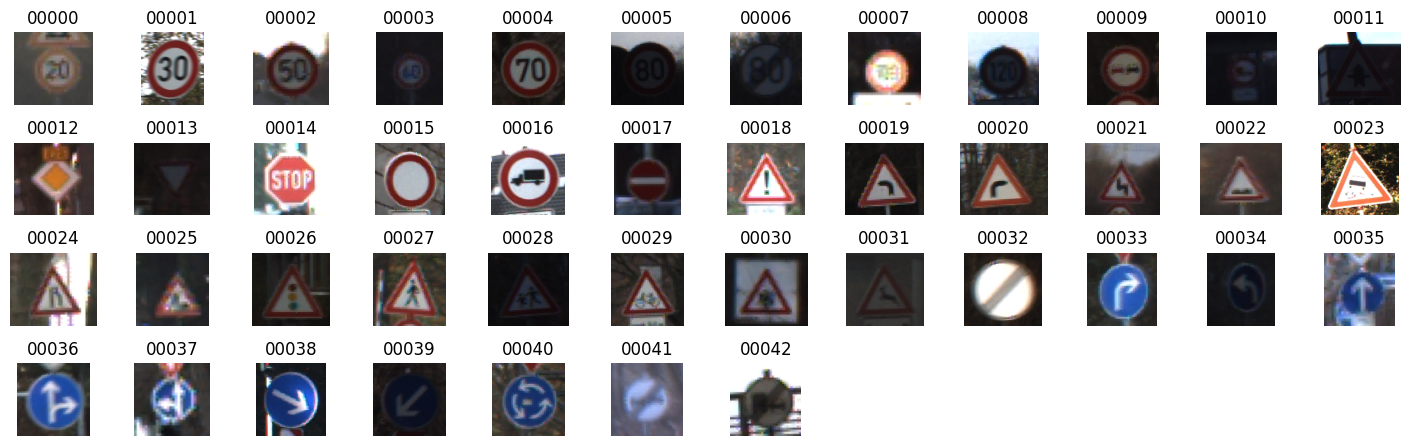

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def visualize_random_image_from_gtsrb(root_dir='GTSRB/Final_Training/Images'):
    class_ids = sorted(os.listdir(root_dir))
    chosen_class = random.choice(class_ids)
    class_dir = os.path.join(root_dir, chosen_class)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.ppm')]
    chosen_image = random.choice(image_files)
    image_path = os.path.join(class_dir, chosen_image)

    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Class: {chosen_class}")
    plt.axis('off')
    plt.show()

def visualize_multiple_images(root_dir='GTSRB/Final_Training/Images', num_classes=43):
    class_ids = sorted(os.listdir(root_dir))

    cols = 12  # 12 images per row
    rows = (num_classes + cols - 1) // cols  # Round up to get number of rows

    plt.figure(figsize=(cols * 1.2, rows * 1.2))  # Slightly larger figure size

    for idx, class_id in enumerate(class_ids):
        class_dir = os.path.join(root_dir, class_id)
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.ppm')]
        chosen_image = random.choice(image_files)
        image_path = os.path.join(class_dir, chosen_image)
        img = mpimg.imread(image_path)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(f"{class_id}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


# Hiển thị nhiều ảnh từ các lớp khác nhau
visualize_multiple_images()


# Kiến trúc LeNet-5



1.  **Lớp C1 (Convolutional Layer):**
    *   Nhận đầu vào là ảnh xám 32x32x1.
    *   Sử dụng 6 bộ lọc (kernel) có kích thước 5x5.
    *   Stride = 1, Padding = 0.
    *   Mỗi bộ lọc kết nối với một vùng 5x5 trên ảnh đầu vào.
    *   Đầu ra là 6 feature map có kích thước 28x28.

2.  **Lớp S2 (Subsampling/Pooling Layer):**
    *   Áp dụng phép Average Pooling với cửa sổ 2x2 và stride 2 trên từng feature map của C1.
    *   Giảm kích thước không gian của mỗi feature map.
    *   Đầu ra là 6 feature map có kích thước 14x14.

3.  **Lớp C3 (Convolutional Layer):**
    *   Sử dụng 16 bộ lọc có kích thước 5x5.
    *   Đây là điểm đặc biệt của LeNet-5: mỗi bộ lọc trong C3 chỉ kết nối với một *tập hợp con* các feature map từ lớp S2 (không phải tất cả). Điều này nhằm giảm số lượng kết nối và tham số.
    *   Stride = 1, Padding = 0.
    *   Đầu ra là 16 feature map có kích thước 10x10.

4.  **Lớp S4 (Subsampling/Pooling Layer):**
    *   Tương tự S2, áp dụng Average Pooling với cửa sổ 2x2 và stride 2 trên từng feature map của C3.
    *   Giảm kích thước không gian.
    *   Đầu ra là 16 feature map có kích thước 5x5.

5.  **Lớp C5 (Convolutional Layer):**
    *   Sử dụng 120 bộ lọc có kích thước 5x5.
    *   Mỗi bộ lọc kết nối với *tất cả* các feature map của lớp S4.
    *   Vì kích thước bộ lọc (5x5) bằng kích thước feature map đầu vào (5x5), đây có thể coi là một lớp tích chập đầy đủ hoặc một lớp Fully Connected trên các feature map đã làm phẳng.
    *   Đầu ra là 120 feature map có kích thước 1x1.

6.  **Lớp F6 (Fully Connected Layer):**
    *   Nhận đầu vào từ 120 đơn vị của lớp C5 (làm phẳng thành vector 120 chiều).
    *   Kết nối đầy đủ với 84 đơn vị.
    *   Sử dụng hàm kích hoạt sigmoid hoặc tanh.

7.  **Lớp Output (Fully Connected Layer):**
    *   Nhận đầu vào từ 84 đơn vị của lớp F6.
    *   Kết nối đầy đủ với số lượng đơn vị bằng số lớp đầu ra (ví dụ: 10 cho MNIST).
    *   Sử dụng hàm kích hoạt Euclidean Radial Basis Function (RBF) hoặc Softmax để đưa ra xác suất cho từng lớp.

| Thành phần   | LeNet-5                 | SimpleCNN_Sequential  |
| ------------ | ----------------------- | ---------------------- |
| Conv1        | Conv với 6 filter 5x5   | Conv với 16 filter 3x3 |
| Pool1        | Average Pooling         | Max Pooling            |
| Conv2        | Conv với 16 filter 5x5  | Conv với 32 filter 3x3 |
| Pool2        | Average Pooling         | Max Pooling            |
| FC1          | 120 neurons             | 128 neurons            |
| FC2 + Output | 84 neurons + 10 classes | FC + 43 classes        |

Điểm khác biệt là:

- Ảnh đầu vào là ảnh màu thay vì ảnh xám

- LeNet dùng Average Pooling, CNN được dùng ở đây sử dụng Max Pooling hiện đại hơn

- LeNet gốc dùng tanh/sigmoid, CNN được dùng ở đây sử dụng ReLU.

- Filter nhỏ hơn (3x3 thay vì 5x5).

- Số lượng filters lớn hơn để tăng khả năng trích xuất đặc trưng.

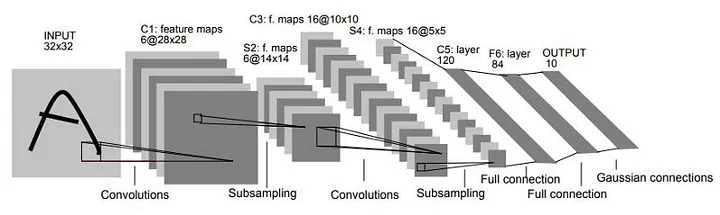

# Importing libraries

In [ ]:
import numpy as np
import cv2
import time

from numba import jit, prange, cuda
import numba as nb
from numba.cuda import local, shared
import math
import pandas as pd

# Data preprocessing

Resize ảnh về 32x32

Chuyển ảnh về kiểu float32 và chuẩn hóa giá trị pixel về khoảng [0, 1], từ kiểu gốc uint8 có giá trị [0, 255]

Chuẩn hóa tiếp ảnh về khoảng [-1, 1] bằng công thức chuẩn hóa chuẩn với giá trị trung bình mean = 0.5, độ lệch chuẩn std = 0.5.

Chuyển thứ tự các chiều ảnh từ HWC → CHW:
- Từ (height, width, channel) → (channel, height, width)
- Đây là định dạng yêu cầu bởi PyTorch khi đưa ảnh vào mô hình (torch.Tensor expects CHW).

In [ ]:
def preprocess_image(image_path):
    """Preprocess single image for GTSRB"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5  # Normalize to [-1, 1]
    img = np.transpose(img, (2, 0, 1))  # CHW format
    return img

def load_gtsrb_data(data_dir):
    """Load and preprocess GTSRB dataset"""
    images = []
    labels = []

    # Read training data
    for class_id in range(43):
        class_dir = os.path.join(data_dir, f"{class_id:05d}")
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.ppm'):
                    img_path = os.path.join(class_dir, img_file)
                    img = preprocess_image(img_path)
                    images.append(img)
                    labels.append(class_id)

    return np.array(images), np.array(labels)

In [ ]:
print("Loading GTSRB data...")
X_train, y_train = load_gtsrb_data("GTSRB/Final_Training/Images")

Loading GTSRB data...


In [ ]:
print(X_train.shape)
print(y_train.shape)

(39209, 3, 32, 32)
(39209,)


In [ ]:
all_results = pd.DataFrame(columns=['Runtime (sec)', 'Speedup'], dtype=float)
all_results

,Runtime (sec),Speedup


In [ ]:
# Loss functions

def cross_entropy_loss(predictions, targets):
    """Calculate cross-entropy loss."""
    # Avoid log(0)
    predictions = np.clip(predictions, 1e-12, 1 - 1e-12)
    N = predictions.shape[0]
    # Use one-hot encoding for targets
    one_hot_targets = np.zeros_like(predictions)
    one_hot_targets[np.arange(N), targets] = 1
    loss = -np.sum(one_hot_targets * np.log(predictions)) / N
    return loss

def cross_entropy_loss_backward(predictions, targets):
    """Calculate the gradient of the cross-entropy loss with respect to the predictions."""
    N = predictions.shape[0]
    grad = predictions.copy()
    grad[np.arange(N), targets] -= 1
    grad /= N
    return grad

def train(model, X_train, y_train, learning_rate, num_epochs, batch_size):
    """Trains the CNN model."""
    num_samples = X_train.shape[0]

    for epoch in range(num_epochs):
        # Shuffle data
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]

        epoch_loss = 0
        num_batches = num_samples // batch_size

        for i in range(num_batches):
            # Get batch
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward pass
            predictions = model.forward(X_batch)

            # Calculate loss
            loss = cross_entropy_loss(predictions, y_batch)
            epoch_loss += loss

            # Backward pass
            grad_output = cross_entropy_loss_backward(predictions, y_batch)
            grads = model.backward(grad_output)

            # Update weights
            model.update(grads, learning_rate)

        # Print loss per epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/num_batches:.4f}")


# Các phiên bản

## 1. Phiên bản tuần tự 1 (numpy)

### 1.1 Thiết kế của SimpleCNN_Sequential

Phiên bản `SimpleCNN_Sequential` là triển khai mạng nơ-ron tích chập (CNN) cơ bản sử dụng hoàn toàn các phép toán trên mảng của thư viện NumPy. Thiết kế của mạng bao gồm các lớp phổ biến trong các kiến trúc CNN đơn giản:

1.  **Lớp Tích chập 1 (Conv1):**
    *   Áp dụng 16 bộ lọc có kích thước 3x3.
    *   Đầu vào có 3 kênh màu (RGB).
    *   Sử dụng stride là 1 và padding là 1.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 16, 32, 32) từ đầu vào (Batch Size, 3, 32, 32).

2.  **Lớp Kích hoạt 1 (ReLU1):**
    *   Áp dụng hàm kích hoạt ReLU (Rectified Linear Unit) cho đầu ra của lớp Conv1.
    *   Kích thước đầu ra không đổi.

3.  **Lớp Max Pooling 1 (Pool1):**
    *   Thực hiện phép Max Pooling với kernel size 2x2 và stride 2.
    *   Giảm kích thước không gian của đầu ra.
    *   Kích thước đầu ra: (Batch Size, 16, 16, 16).

4.  **Lớp Tích chập 2 (Conv2):**
    *   Áp dụng 32 bộ lọc có kích thước 3x3.
    *   Đầu vào có 16 kênh (từ Pool1).
    *   Sử dụng stride là 1 và padding là 1.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 32, 16, 16).

5.  **Lớp Kích hoạt 2 (ReLU2):**
    *   Áp dụng hàm kích hoạt ReLU cho đầu ra của lớp Conv2.
    *   Kích thước đầu ra không đổi.

6.  **Lớp Max Pooling 2 (Pool2):**
    *   Thực hiện phép Max Pooling với kernel size 2x2 và stride 2.
    *   Giảm kích thước không gian của đầu ra.
    *   Kích thước đầu ra: (Batch Size, 32, 8, 8).

7.  **Lớp Làm phẳng (Flatten):**
    *   Chuyển đổi đầu ra từ lớp Pool2 (tensor 4D) thành một vector 1D cho mỗi mẫu trong batch.
    *   Kích thước đầu ra: (Batch Size, 32, 8, 8).

8.  **Lớp Kết nối đầy đủ 1 (FC1):**
    *   Một lớp tuyến tính (Fully Connected) nhận đầu vào từ lớp Flatten.
    *   Số lượng đơn vị (neuron) là 128.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 128).

9.  **Lớp Kích hoạt 3 (ReLU - sau FC1):**
    *   Áp dụng hàm kích hoạt ReLU cho đầu ra của lớp FC1.
    *   Kích thước đầu ra không đổi.

10. **Lớp Kết nối đầy đủ 2 (FC2):**
    *   Một lớp tuyến tính (Fully Connected) nhận đầu vào từ lớp ReLU sau FC1.
    *   Số lượng đơn vị (neuron) bằng số lớp đầu ra (43 lớp biển báo giao thông).
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 43).

11. **Lớp Softmax:**
    *   Áp dụng hàm Softmax cho đầu ra của lớp FC2 để thu được xác suất cho mỗi lớp.
    *   Kích thước đầu ra không đổi.

Mô hình này thực hiện cả quá trình truyền xuôi (forward pass) và lan truyền ngược (backward pass) cho việc huấn luyện, tính toán gradient cho từng tham số (trọng số và bias) của các lớp tích chập và lớp kết nối đầy đủ. Tất cả các phép tính được thực hiện tuần tự trên CPU bằng NumPy.

### 1.2 Cài đặt

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_backward(grad_output, x):
    grad_x = grad_output * (x > 0)
    return grad_x

def softmax(x):
    exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

# No backward needed for Softmax directly for cross-entropy
def max_pool2d(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))

    for b in range(B):
        for c in range(C):
            for i in range(0, H - size + 1, stride):
                for j in range(0, W - size + 1, stride):
                    window = x[b, c, i:i+size, j:j+size]
                    out[b, c, i//stride, j//stride] = np.max(window)
    return out

def max_pool2d_backward(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    for b in range(B):
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    window = x[b, c, h_start:h_start+size, w_start:w_start+size]
                    max_val = np.max(window)
                    mask = (window == max_val)
                    # Propagate gradient to the location of the maximum value
                    # Need to handle potential multiple max values - broadcasting correctly
                    grad_x[b, c, h_start:h_start+size, w_start:w_start+size] += grad_output[b, c, i, j] * mask
    return grad_x

def conv2d(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Pad input
    if padding > 0:
        x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
        x_padded[:, :, padding:-padding, padding:-padding] = x
    else:
        x_padded = x

    out = np.zeros((B, C_out, H_out, W_out))

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    window = x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
                    out[b, c_out, i, j] = np.sum(window * weight[c_out]) + bias[c_out]
    return out

def conv2d_backward(grad_output, x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape # Corrected output shape
    # B_out should be equal to B

    grad_x = np.zeros_like(x)
    grad_weight = np.zeros_like(weight)
    grad_bias = np.sum(grad_output, axis=(0, 2, 3))

    # Pad input and grad_x for easier calculation
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    x_padded[:, :, padding:-padding, padding:-padding] = x
    grad_x_padded = np.zeros_like(x_padded)

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    window = x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
                    # Calculate grad_weight for this output pixel
                    grad_weight[c_out] += window * grad_output[b, c_out, i, j]
                    # Calculate grad_x_padded for this output pixel contribution
                    grad_x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW] += weight[c_out] * grad_output[b, c_out, i, j]


    # Unpad grad_x
    grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]

    return grad_x, grad_weight, grad_bias

class SimpleCNN_Sequential:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)

        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()
        # Store timings for both forward and backward passes distinctly
        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}
        # Corrected logic to determine pass type
        pass_type = 'forward'
        # Check for known backward layer names
        backward_keywords = ['backward', '_bwd', '_grad', '_input', '_weight', '_bias']
        if any(keyword in layer_name for keyword in backward_keywords):
             pass_type = 'backward'
        # Removed the problematic check for args in intermediate_values


        if pass_type not in self.layer_timings[layer_name]:
             self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        conv1_out = self._time_layer('conv1_forward', conv2d, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = conv1_out

        # ReLU1
        relu1_out = self._time_layer('relu1_forward', relu, conv1_out)
        self.intermediate_values['relu1_out'] = relu1_out

        # Pool1
        pool1_out = self._time_layer('pool1_forward', max_pool2d, relu1_out)
        self.intermediate_values['pool1_out'] = pool1_out

        # Conv2
        conv2_out = self._time_layer('conv2_forward', conv2d, pool1_out, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = conv2_out

        # ReLU2
        relu2_out = self._time_layer('relu2_forward', relu, conv2_out)
        self.intermediate_values['relu2_out'] = relu2_out

        # Pool2
        pool2_out = self._time_layer('pool2_forward', max_pool2d, relu2_out)
        self.intermediate_values['pool2_out'] = pool2_out

        # Flatten
        flattened_shape = (pool2_out.shape[0], -1)
        x_flat = pool2_out.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        fc1_out = self._time_layer('fc1_forward', relu, fc1_linear)
        self.intermediate_values['fc1_out'] = fc1_out

        # FC2
        fc2_linear = fc1_out @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', np.sum, grad_fc2_linear, axis=0)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)


        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = self._time_layer('fc1_bias_backward', np.sum, grad_fc1_linear, axis=0)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', lambda g, x: x.T @ g, grad_fc1_linear, self.intermediate_values['flatten_out'])
        grad_flatten_out = self._time_layer('fc1_input_backward', lambda g, w: g @ w.T, grad_fc1_linear, self.fc1_w)


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_backward, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)


        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward, grad_relu2_out, self.intermediate_values['conv2_out'])


        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'], grads['conv2_b'] = self._time_layer('conv2_backward', conv2d_backward,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            self.conv2_b,
            stride=1,
            padding=1
        )


        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)


        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward, grad_relu1_out, self.intermediate_values['conv1_out'])


        # Backprop through Conv1
        grad_x, grads['conv1_w'], grads['conv1_b'] = self._time_layer('conv1_backward', conv2d_backward,
            grad_conv1_out,
            self.intermediate_values['x'],
            self.conv1_w,
            self.conv1_b,
            stride=1,
            padding=1
        )

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']


    def get_timings_df(self):
        df_list = []
        for layer, times in self.layer_timings.items():
            for pass_type, time_taken in times.items():
                df_list.append({'Layer': layer, 'Pass': pass_type, 'Time (s)': time_taken, 'Time (ms)': time_taken * 1000})
        return pd.DataFrame(df_list).round(6)


    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 1.3 Đánh giá

Nhằm tiết kiệm thời gian, tất cả phiên bản sẽ chỉ train đúng 1 epoch trên 32 ảnh đầu tiên của dataset
- Thời gian chạy các phiên bản sẽ được lưu vào dataframe để dễ theo dõi và so sánh độ cải thiện.
- Về tính đúng đắn: predicted labels của bản tuần tự 1 sẽ được lấy làm chuẩn để so sánh với các phiên bản sau.

Cuối cùng, phiên bản nhanh nhất sẽ được train trên toàn bộ dataset với số epoch lớn hơn ⟶ đánh giá bằng các matric (acc, recall, f1,...)

#### Thời gian chạy

In [ ]:
# Initialize models
model_seq = SimpleCNN_Sequential()

# Perform forward and backward pass for each model on a batch
batch_size = 32
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU
print("--- SimpleCNN_Sequential Timings ---")
start_time = time.time()

predictions_seq = model_seq.forward(X_batch)
grad_output_seq = cross_entropy_loss_backward(predictions_seq, y_batch)
grads_seq = model_seq.backward(grad_output_seq)
display(model_seq.get_timings_df())

end_time = time.time()
seq_time = end_time - start_time
print("\n")

--- SimpleCNN_Sequential Timings ---


,Layer,Pass,Time (s),Time (ms)
0,conv1_forward,forward,3.079171,3079.171419
1,relu1_forward,forward,0.001050,1.049519
2,pool1_forward,forward,0.494610,494.609594
3,conv2_forward,forward,1.721744,1721.743822
4,relu2_forward,forward,0.000500,0.499725
5,pool2_forward,forward,0.252424,252.424479
6,fc1_forward,forward,0.000025,0.025034
7,fc2_forward,forward,0.000075,0.074863
8,fc2_bias_backward,backward,0.000017,0.016689
9,fc2_weight_backward,backward,0.000025,0.024557


 Các layer tốn nhiều thời gian tính toán chủ yếu là convolutional và max_pooling
 <br>--> Cần tập trung vào các layer này

In [ ]:
# Display results in a DataFrame

all_results.loc['Sequential 1: numpy operation', 'Runtime (sec)'] = seq_time
all_results.loc['Sequential 1: numpy operation', 'Speedup'] = 1.0  # Base case

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)


--- Overall Model Runtime Comparison ---


,Runtime (sec),Speedup
Sequential 1: numpy operation,15.767797,1.0


## 2. Phiên bản tuần tự 2: dùng Numba để biên dịch hàm Python ra mã máy và chạy tuần tự trên CPU/host

### 2.1 Thiết kế của SimpleCNN_SequentialNumba

Phiên bản `SimpleCNN_SequentialNumba` có cùng cấu trúc mạng (số lớp, kích thước kernel, stride, padding, số neuron) như `SimpleCNN_Sequential`. Điểm khác biệt chính nằm ở việc triển khai các phép toán cơ bản (như `conv2d`, `max_pool2d`, `relu`, `softmax` và các phiên bản `_backward` tương ứng) sử dụng thư viện Numba với decorator `@jit(nopython=True)`.

 decorator `@jit(nopython=True)` của Numba biên dịch các hàm Python sang mã máy hiệu quả, loại bỏ overhead của trình thông dịch Python và thường mang lại cải thiện đáng kể về tốc độ thực thi trên CPU.

Thiết kế mạng vẫn bao gồm các lớp:

1.  **Lớp Tích chập 1 (Conv1) - Numba JIT:** Áp dụng hàm `conv2d` đã được JIT.
2.  **Lớp Kích hoạt 1 (ReLU1) - Numba JIT:** Áp dụng hàm `relu` đã được JIT.
3.  **Lớp Max Pooling 1 (Pool1) - Numba JIT:** Áp dụng hàm `max_pool2d` đã được JIT.
4.  **Lớp Tích chập 2 (Conv2) - Numba JIT:** Áp dụng hàm `conv2d` đã được JIT.
5.  **Lớp Kích hoạt 2 (ReLU2) - Numba JIT:** Áp dụng hàm `relu` đã được JIT.
6.  **Lớp Max Pooling 2 (Pool2) - Numba JIT:** Áp dụng hàm `max_pool2d` đã được JIT.
7.  **Lớp Làm phẳng (Flatten):** Vẫn sử dụng thao tác `reshape` của NumPy (thường đủ nhanh).
8.  **Lớp Kết nối đầy đủ 1 (FC1):** Sử dụng phép nhân ma trận `@` của NumPy (đã được Numba tối ưu hóa khi dùng `@jit`). Áp dụng hàm `relu` đã được JIT sau đó.
9.  **Lớp Kết nối đầy đủ 2 (FC2):** Sử dụng phép nhân ma trận `@` của NumPy. Áp dụng hàm `softmax` đã được JIT sau đó.

Tương tự, quá trình lan truyền ngược (`backward`) cũng sử dụng các hàm `_backward` tương ứng đã được JIT hóa bởi Numba. Việc biên dịch này giúp cải thiện hiệu suất tính toán trên CPU so với phiên bản NumPy thuần túy.

### 2.2 Cài đặt

In [ ]:
@jit(nopython=True)
def relu(x):
    return np.maximum(0, x)

@jit(nopython=True)
def softmax(x):
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        max_val = np.max(x[i])
        exp_vals = np.exp(x[i] - max_val)
        out[i] = exp_vals / np.sum(exp_vals)
    return out

@jit(nopython=True)
def max_pool2d(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))

    for b in range(B):
        for c in range(C):
            for i in range(0, H - size + 1, stride):
                for j in range(0, W - size + 1, stride):
                    max_val = x[b, c, i, j]
                    for ki in range(size):
                        for kj in range(size):
                            val = x[b, c, i + ki, j + kj]
                            if val > max_val:
                                max_val = val
                    out[b, c, i//stride, j//stride] = max_val
    return out

@jit(nopython=True)
def conv2d(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Create padded input
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in range(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    out = np.zeros((B, C_out, H_out, W_out))

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    conv_sum = 0.0
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                h_idx = i * stride + ki
                                w_idx = j * stride + kj
                                conv_sum += x_padded[b, c_in, h_idx, w_idx] * weight[c_out, c_in, ki, kj]
                    out[b, c_out, i, j] = conv_sum + bias[c_out]
    return out

@jit(nopython=True)
def relu_backward(grad_output, x):
    grad_x = np.zeros_like(grad_output)
    for i in range(grad_output.size):
        if x.flat[i] > 0:
            grad_x.flat[i] = grad_output.flat[i]
    return grad_x

@jit(nopython=True)
def max_pool2d_backward(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    for b in range(B):
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    max_val = -np.inf # Use negative infinity for max_val init
                    max_i_local, max_j_local = 0, 0
                    for ki in range(size):
                        for kj in range(size):
                            current_h = h_start + ki
                            current_w = w_start + kj
                            if current_h < H and current_w < W:
                                val = x[b, c, current_h, current_w]
                                if val > max_val:
                                    max_val = val
                                    max_i_local, max_j_local = ki, kj
                    # Propagate gradient to the location of the maximum value
                    # Need to handle potential multiple max values - broadcasting correctly
                    grad_x[b, c, h_start + max_i_local, w_start + max_j_local] += grad_output[b, c, i, j]
    return grad_x

@jit(nopython=True)
def conv2d_backward(grad_output, x, weight, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape

    grad_x = np.zeros_like(x)
    grad_weight = np.zeros_like(weight)

    # Pad input and grad_x for easier calculation
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in range(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    grad_x_padded = np.zeros_like(x_padded)

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    # Calculate grad_weight
                    for c_in in range(C_in):
                         for ki in range(kH):
                             for kj in range(kW):
                                 grad_weight[c_out, c_in, ki, kj] += x_padded[b, c_in, h_start + ki, w_start + kj] * grad_output[b, c_out, i, j]

                    # Calculate grad_x_padded
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                grad_x_padded[b, c_in, h_start + ki, w_start + kj] += weight[c_out, c_in, ki, kj] * grad_output[b, c_out, i, j]

    # Unpad grad_x
    grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]

    return grad_x, grad_weight

@jit(nopython=True)
def compute_grad_bias(grad_output):
    """Compute gradient with respect to bias for Conv2d/FC (parallel CPU)."""
    if grad_output.ndim == 2: # For FC layers
        return np.sum(grad_output, axis=0)
    elif grad_output.ndim == 4: # For Conv layers
         # Sum sequentially over axes 0, 2, and 3
         sum_batch = np.sum(grad_output, axis=0)
         sum_h = np.sum(sum_batch, axis=1)
         sum_w = np.sum(sum_h, axis=1)
         return sum_w
    else:
        # Handle other dimensions if necessary, or raise an error
        return np.zeros(grad_output.shape[1], dtype=grad_output.dtype)


# Modify SimpleCNN_CPU to store intermediate values and implement backward
class SimpleCNN_SequentialNumba:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)
        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

        # Calculate flatten size: 32x32 -> 16x16 -> 8x8 with 32 channels
        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()
        # Store timings for both forward and backward passes distinctly
        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}

        pass_type = 'forward'
        # Heuristic to determine if it's a backward pass based on layer name
        backward_keywords = ['backward', '_bwd', '_grad', '_input', '_weight', '_bias']
        if any(keyword in layer_name for keyword in backward_keywords):
             pass_type = 'backward'
        elif len(args) > 0 and id(args[0]) in [id(v) for v in self.intermediate_values.values()]:
            # Another heuristic: if the first argument is a stored intermediate value, it's likely backward
             pass_type = 'backward'


        if pass_type not in self.layer_timings[layer_name]:
             self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        x = self._time_layer('conv1_forward', conv2d, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = x

        # ReLU1
        x = self._time_layer('relu1_forward', relu, x)
        self.intermediate_values['relu1_out'] = x

        # Pool1
        x = self._time_layer('pool1_forward', max_pool2d, x)
        self.intermediate_values['pool1_out'] = x

        # Conv2
        x = self._time_layer('conv2_forward', conv2d, x, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = x

        # ReLU2
        x = self._time_layer('relu2_forward', relu, x)
        self.intermediate_values['relu2_out'] = x

        # Pool2
        x = self._time_layer('pool2_forward', max_pool2d, x)
        self.intermediate_values['pool2_out'] = x

        # Flatten
        flattened_shape = (x.shape[0], -1)
        x_flat = x.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        x = self._time_layer('fc1_forward', relu, fc1_linear)
        self.intermediate_values['fc1_out'] = x

        # FC2
        fc2_linear = x @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', compute_grad_bias, grad_fc2_linear)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)

        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = compute_grad_bias(grad_fc1_linear)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', self.intermediate_values['flatten_out'].T.__matmul__, grad_fc1_linear) # Using __matmul__ for Numba compatibility
        grad_flatten_out = self._time_layer('fc1_input_backward', grad_fc1_linear.__matmul__, self.fc1_w.T) # Using __matmul__ for Numba compatibility


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_backward, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)

        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'] = self._time_layer('conv2_weight_input_backward', conv2d_backward,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            stride=1,
            padding=1
        )
        grads['conv2_b'] = self._time_layer('conv2_bias_backward', compute_grad_bias, grad_conv2_out)

        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        # The gradient to the input of the first convolution layer comes from the output of the first ReLU layer's backward pass
        grad_x, grads['conv1_w'] = self._time_layer('conv1_weight_input_backward', conv2d_backward,
            grad_conv1_out, # Use the gradient from the ReLU layer's backward pass
            self.intermediate_values['x'],
            self.conv1_w,
            stride=1,
            padding=1
        )
        grads['conv1_b'] = compute_grad_bias(grad_conv1_out)

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        df_list = []
        for layer, times in self.layer_timings.items():
            for pass_type, time_taken in times.items():
                df_list.append({'Layer': layer, 'Pass': pass_type, 'Time (s)': time_taken, 'Time (ms)': time_taken * 1000})
        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 2.3 Đánh giá

#### Thời gian chạy

In [ ]:
# Initialize models
model_seq_numba = SimpleCNN_SequentialNumba()

# Perform forward and backward pass for each model on a batch
batch_size = 32
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU
print("--- SimpleCNN_Sequential_Numba Timings ---")
start_time = time.time()

predictions_seq_numba = model_seq_numba.forward(X_batch)
grad_output_seq_numba = cross_entropy_loss_backward(predictions_seq_numba, y_batch)
grads_seq_numba = model_seq_numba.backward(grad_output_seq_numba)
display(model_seq_numba.get_timings_df())

end_time = time.time()
seq_time_numba = end_time - start_time

--- SimpleCNN_Sequential_Numba Timings ---


,Layer,Pass,Time (s),Time (ms)
0,conv1_forward,backward,1.020557,1020.557404
1,relu1_forward,backward,0.219912,219.911575
2,pool1_forward,backward,0.195719,195.719481
3,conv2_forward,backward,0.601875,601.875305
4,relu2_forward,backward,0.000477,0.477076
5,pool2_forward,backward,0.000347,0.347376
6,fc1_forward,backward,0.173989,173.989058
7,fc2_forward,backward,0.822880,822.880268
8,fc2_bias_backward,backward,1.110256,1110.256433
9,fc2_weight_backward,backward,0.000065,0.065327


In [ ]:
# Display results in a DataFrame

all_results.loc['Sequential 2: @jit', 'Runtime (sec)'] = seq_time_numba
all_results.loc['Sequential 2: @jit', 'Speedup'] = seq_time/seq_time_numba

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n\n")


--- Overall Model Runtime Comparison ---


,Runtime (sec),Speedup
Sequential 1: numpy operation,15.767797,1.000000
Sequential 2: @jit,11.897726,1.325278


#### Tính đúng đắn

In [ ]:
print(f"Output difference: {np.mean(np.abs(predictions_seq - predictions_seq_numba)):.6f}")

Output difference: 0.025660


## 3. Phiên bản song song 1 : dùng Numba để biên dịch hàm Python ra mã máy và chạy song song trên CPU/host

### 3.1 Thiết kế của SimpleCNN_CPU

Phiên bản `SimpleCNN_CPU` dựa trên `SimpleCNN_SequentialNumba` nhưng tận dụng khả năng song song hóa trên CPU của Numba bằng cách thêm tùy chọn `parallel=True` vào decorator `@jit`. Các hàm toán tử (như `conv2d_parallel`, `max_pool2d_parallel`, `relu_parallel`, `softmax_parallel` và các phiên bản `_backward_parallel`) được thiết kế để Numba có thể phân phối công việc trên nhiều lõi CPU.

Cấu trúc mạng và các lớp vẫn giữ nguyên như các phiên bản trước:

1.  **Lớp Tích chập 1 (Conv1) - Numba Parallel:** Áp dụng hàm `conv2d_parallel` sử dụng `@jit(parallel=True)`.
2.  **Lớp Kích hoạt 1 (ReLU1) - Numba Parallel:** Áp dụng hàm `relu_parallel` sử dụng `@jit(parallel=True)`.
3.  **Lớp Max Pooling 1 (Pool1) - Numba Parallel:** Áp dụng hàm `max_pool2d_parallel` sử dụng `@jit(parallel=True)`.
4.  **Lớp Tích chập 2 (Conv2) - Numba Parallel:** Áp dụng hàm `conv2d_parallel` sử dụng `@jit(parallel=True)`.
5.  **Lớp Kích hoạt 2 (ReLU2) - Numba Parallel:** Áp dụng hàm `relu_parallel` sử dụng `@jit(parallel=True)`.
6.  **Lớp Max Pooling 2 (Pool2) - Numba Parallel:** Áp dụng hàm `max_pool2d_parallel` sử dụng `@jit(parallel=True)`.
7.  **Lớp Làm phẳng (Flatten):** Vẫn sử dụng `reshape` của NumPy.
8.  **Lớp Kết nối đầy đủ 1 (FC1):** Sử dụng phép nhân ma trận `@` của NumPy (có thể được Numba tối ưu hóa), kết hợp với `relu_parallel`.
9.  **Lớp Kết nối đầy đủ 2 (FC2):** Sử dụng phép nhân ma trận `@` của NumPy, kết hợp với `softmax_parallel`.

Các hàm lan truyền ngược cũng sử dụng các phiên bản `_parallel` tương ứng. Bằng cách khai thác tính năng song song của Numba trên CPU, phiên bản này nhằm mục đích giảm thời gian thực thi tổng thể bằng cách phân tán các phép tính trên các lõi xử lý có sẵn. Hiệu quả song song hóa phụ thuộc vào bản chất của từng phép toán và cách Numba có thể phân tích và song song hóa các vòng lặp trong hàm.

### 3.2 Cài đặt

In [ ]:
from numba import config
config.THREADING_LAYER = 'omp'

# Numba JIT functions (already defined)
@jit(nopython=True, parallel=True)
def relu_parallel(x):
    return np.maximum(0, x)

@jit(nopython=True, parallel=True)
def softmax_parallel(x):
    out = np.zeros_like(x)
    for i in prange(x.shape[0]):
        max_val = np.max(x[i])
        exp_vals = np.exp(x[i] - max_val)
        out[i] = exp_vals / np.sum(exp_vals)
    return out

@jit(nopython=True, parallel=True)
def max_pool2d_parallel(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))

    for b in prange(B):
        for c in prange(C):
            for i in range(0, H - size + 1, stride):
                for j in range(0, W - size + 1, stride):
                    max_val = x[b, c, i, j]
                    for ki in range(size):
                        for kj in range(size):
                            val = x[b, c, i + ki, j + kj]
                            if val > max_val:
                                max_val = val
                    out[b, c, i//stride, j//stride] = max_val
    return out

@jit(nopython=True, parallel=True)
def conv2d_parallel(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Create padded input
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in prange(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    out = np.zeros((B, C_out, H_out, W_out))

    for b in prange(B):
        for c_out in prange(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    conv_sum = 0.0
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                h_idx = i * stride + ki
                                w_idx = j * stride + kj
                                conv_sum += x_padded[b, c_in, h_idx, w_idx] * weight[c_out, c_in, ki, kj]
                    out[b, c_out, i, j] = conv_sum + bias[c_out]
    return out

@jit(nopython=True, parallel=True)
def relu_backward_parallel(grad_output, x):
    grad_x = np.zeros_like(grad_output)
    for i in prange(grad_output.size):
        if x.flat[i] > 0:
            grad_x.flat[i] = grad_output.flat[i]
    return grad_x

@jit(nopython=True, parallel=True)
def max_pool2d_backward_parallel(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    for b in prange(B):
        for c in prange(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    max_val = -np.inf # Use negative infinity for max_val init
                    max_i_local, max_j_local = 0, 0
                    for ki in range(size):
                        for kj in range(size):
                            current_h = h_start + ki
                            current_w = w_start + kj
                            if current_h < H and current_w < W:
                                val = x[b, c, current_h, current_w]
                                if val > max_val:
                                    max_val = val
                                    max_i_local, max_j_local = ki, kj
                    # Propagate gradient to the location of the maximum value
                    # Need to handle potential multiple max values - broadcasting correctly
                    grad_x[b, c, h_start + max_i_local, w_start + max_j_local] += grad_output[b, c, i, j]
    return grad_x

@jit(nopython=True, parallel=True)
def conv2d_backward_parallel(grad_output, x, weight, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape

    grad_x = np.zeros_like(x)
    grad_weight = np.zeros_like(weight)

    # Pad input and grad_x for easier calculation
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in prange(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    grad_x_padded = np.zeros_like(x_padded)

    for b in prange(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    # Calculate grad_weight
                    for c_in in range(C_in):
                         for ki in range(kH):
                             for kj in range(kW):
                                 grad_weight[c_out, c_in, ki, kj] += x_padded[b, c_in, h_start + ki, w_start + kj] * grad_output[b, c_out, i, j]

                    # Calculate grad_x_padded
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                grad_x_padded[b, c_in, h_start + ki, w_start + kj] += weight[c_out, c_in, ki, kj] * grad_output[b, c_out, i, j]

    # Unpad grad_x
    grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]

    return grad_x, grad_weight

@jit(nopython=True, parallel=True)
def compute_grad_bias_parallel(grad_output):
    """Compute gradient with respect to bias for Conv2d/FC (parallel CPU)."""
    if grad_output.ndim == 2: # For FC layers
        return np.sum(grad_output, axis=0)
    elif grad_output.ndim == 4: # For Conv layers
         # Sum sequentially over axes 0, 2, and 3
         sum_batch = np.sum(grad_output, axis=0)
         sum_h = np.sum(sum_batch, axis=1)
         sum_w = np.sum(sum_h, axis=1)
         return sum_w
    else:
        # Handle other dimensions if necessary, or raise an error
        return np.zeros(grad_output.shape[1], dtype=grad_output.dtype)


# Modify SimpleCNN_CPU to store intermediate values and implement backward
class SimpleCNN_CPU:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)
        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

        # Calculate flatten size: 32x32 -> 16x16 -> 8x8 with 32 channels
        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()
        # Store timings for both forward and backward passes distinctly
        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}

        pass_type = 'forward'
        # Heuristic to determine if it's a backward pass based on layer name
        backward_keywords = ['backward', '_bwd', '_grad', '_input', '_weight', '_bias']
        if any(keyword in layer_name for keyword in backward_keywords):
             pass_type = 'backward'
        elif len(args) > 0 and id(args[0]) in [id(v) for v in self.intermediate_values.values()]:
            # Another heuristic: if the first argument is a stored intermediate value, it's likely backward
             pass_type = 'backward'


        if pass_type not in self.layer_timings[layer_name]:
             self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        x = self._time_layer('conv1_forward', conv2d_parallel, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = x

        # ReLU1
        x = self._time_layer('relu1_forward', relu_parallel, x)
        self.intermediate_values['relu1_out'] = x

        # Pool1
        x = self._time_layer('pool1_forward', max_pool2d_parallel, x)
        self.intermediate_values['pool1_out'] = x

        # Conv2
        x = self._time_layer('conv2_forward', conv2d_parallel, x, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = x

        # ReLU2
        x = self._time_layer('relu2_forward', relu_parallel, x)
        self.intermediate_values['relu2_out'] = x

        # Pool2
        x = self._time_layer('pool2_forward', max_pool2d_parallel, x)
        self.intermediate_values['pool2_out'] = x

        # Flatten
        flattened_shape = (x.shape[0], -1)
        x_flat = x.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        x = self._time_layer('fc1_forward', relu_parallel, fc1_linear)
        self.intermediate_values['fc1_out'] = x

        # FC2
        fc2_linear = x @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax_parallel, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', compute_grad_bias_parallel, grad_fc2_linear)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)

        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward_parallel, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = compute_grad_bias_parallel(grad_fc1_linear)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', self.intermediate_values['flatten_out'].T.__matmul__, grad_fc1_linear) # Using __matmul__ for Numba compatibility
        grad_flatten_out = self._time_layer('fc1_input_backward', grad_fc1_linear.__matmul__, self.fc1_w.T) # Using __matmul__ for Numba compatibility


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_backward_parallel, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)

        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward_parallel, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'] = self._time_layer('conv2_weight_input_backward', conv2d_backward_parallel,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            stride=1,
            padding=1
        )
        grads['conv2_b'] = self._time_layer('conv2_bias_backward', compute_grad_bias_parallel, grad_conv2_out)

        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward_parallel, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward_parallel, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        # The gradient to the input of the first convolution layer comes from the output of the first ReLU layer's backward pass
        grad_x, grads['conv1_w'] = self._time_layer('conv1_weight_input_backward', conv2d_backward_parallel,
            grad_conv1_out, # Use the gradient from the ReLU layer's backward pass
            self.intermediate_values['x'],
            self.conv1_w,
            stride=1,
            padding=1
        )
        grads['conv1_b'] = compute_grad_bias_parallel(grad_conv1_out)

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        df_list = []
        for layer, times in self.layer_timings.items():
            for pass_type, time_taken in times.items():
                df_list.append({'Layer': layer, 'Pass': pass_type, 'Time (s)': time_taken, 'Time (ms)': time_taken * 1000})
        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 3.3 Đánh giá

#### Thời gian chạy

In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [ ]:
# Chạy trước với dữ liệu nhỏ để compile code

# Initialize models
model_cpu = SimpleCNN_CPU()

# Perform forward and backward pass for each model on a batch
batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Parallel CPU (Numba)
print("--- SimpleCNN_CPU Timings ---")
start_time = time.time()

predictions_cpu = model_cpu.forward(X_batch)
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu, y_batch)
grads_cpu = model_cpu.backward(grad_output_cpu)
display(model_cpu.get_timings_df())

end_time = time.time()
cpu_time = end_time - start_time

--- SimpleCNN_CPU Timings ---


/usr/local/lib/python3.11/dist-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../tmp/ipython-input-33-3220865634.py", line 148:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/usr/local/lib/python3.11/dist-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../tmp/ipython-input-33-3220865634.py", line 148:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


,Layer,Pass,Time (s),Time (ms)
0,conv1_forward,backward,2.535915,2535.915136
1,relu1_forward,backward,0.537281,537.281036
2,pool1_forward,backward,1.351039,1351.038933
3,conv2_forward,backward,2.430822,2430.822134
4,relu2_forward,backward,0.000021,0.020742
5,pool2_forward,backward,0.000041,0.041246
6,fc1_forward,backward,0.619651,619.650841
7,fc2_forward,backward,1.670292,1670.291901
8,fc2_bias_backward,backward,1.005506,1005.505562
9,fc2_weight_backward,backward,0.000082,0.082493


In [ ]:
# Initialize models
model_cpu = SimpleCNN_CPU()

# Perform forward and backward pass for each model on a batch
batch_size = 32
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Parallel CPU (Numba)
print("--- SimpleCNN_CPU Timings ---")
start_time = time.time()

predictions_cpu = model_cpu.forward(X_batch)
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu, y_batch)
grads_cpu = model_cpu.backward(grad_output_cpu)
display(model_cpu.get_timings_df())

end_time = time.time()
cpu_time = end_time - start_time

--- SimpleCNN_CPU Timings ---


,Layer,Pass,Time (s),Time (ms)
0,conv1_forward,backward,0.025544,25.544405
1,relu1_forward,backward,0.000552,0.551701
2,pool1_forward,backward,0.003176,3.176212
3,conv2_forward,backward,0.065471,65.471172
4,relu2_forward,backward,0.000306,0.305653
5,pool2_forward,backward,0.000588,0.588417
6,fc1_forward,backward,0.011988,11.988163
7,fc2_forward,backward,0.009718,9.718418
8,fc2_bias_backward,backward,0.000013,0.012875
9,fc2_weight_backward,backward,0.000049,0.048637


In [ ]:
# Display results in a DataFrame

all_results.loc['Parallel 1: @jit(parallel=True)', 'Runtime (sec)'] = cpu_time
all_results.loc['Parallel 1: @jit(parallel=True)', 'Speedup'] = seq_time / cpu_time


print("\n--- Overall Model Runtime Comparison ---")
display(all_results)


--- Overall Model Runtime Comparison ---


,Runtime (sec),Speedup
Sequential 1: numpy operation,15.767797,1.000000
Sequential 2: @jit,11.897726,1.325278
Parallel 1: @jit(parallel=True),0.494135,31.909903


#### Tính đúng đắn

In [ ]:
print(f"Output difference: {np.mean(np.abs(predictions_seq - predictions_cpu)):.6f}")

Output difference: 0.024804
